In [17]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Literal
from pydantic import BaseModel, Field
from dotenv import load_dotenv
load_dotenv()
model = ChatGoogleGenerativeAI(model='gemini-1.5-flash')

In [18]:
class SentimentSchema(BaseModel):
    sentiment : Literal['positive','negative']= Field(description=" Sentiment of the review")

In [19]:
class DignosisSchema(BaseModel):
    issue_type: Literal['UX','Performance','Bug','Support','Other'] = Field(description='The category of issue mentioned in the reviw')
    tone : Literal['angry','frustruted','disspointed','calm']= Field(description='The emotional tone expressed by the user')
    urgency: Literal['low','medium','high']= Field(description='how urgernt or critical the issue appearses to be ')

In [20]:
structured_model= model.with_structured_output(SentimentSchema)
structured_model1= model.with_structured_output(DignosisSchema)

In [21]:
prompt= 'What is the sentiment of following sentence - I will pray for the god today"s day will never come into my life'
structured_model.invoke(prompt).sentiment

'negative'

In [22]:
class ReviewState(TypedDict):
    review:str
    sentiment: Literal['positive','negative']
    dignosis: dict 
    response: str 

In [23]:
def find_sentiment(state: ReviewState):
    prompt = f" For the following review find out the sentiment - {state['review']}"
    sentiment = structured_model.invoke(prompt).sentiment
    return {'sentiment': sentiment}

def check_sentiment(state: ReviewState) -> Literal['positive_response','run_dignosis']:
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        'run_dignosis'

def positive_response(state: ReviewState):
    prompt = f"""
            Write warm thank you message in response to this review - 
            \n {state['review']}
            \n Also, kindly ask user to leave feedback on our website
            """
    response= model.invoke(prompt).content

    return {'response':response}

def run_dignosis(state: ReviewState):
    prompt= f"""
            Dignose this negative review -
            \n {state['review']}
            \n Return issue_type, tone, urgency
            """
    response= structured_model1.invoke(prompt)

    return {'dignosis': response.model_dump()}

def negative_response(state: ReviewState):
    dignosis= state['dignosis']

    prompt= f"""
            You are support assistent.
            The user had a '{dignosis['issue_type']}' issue, sounded '{dignosis['tone']}', and marked urgency as '{dignosis['urgency']}'.
            write an empathetic, helpful resolution message.
            """
    response= model.invoke(prompt).content
    return {'response':response}

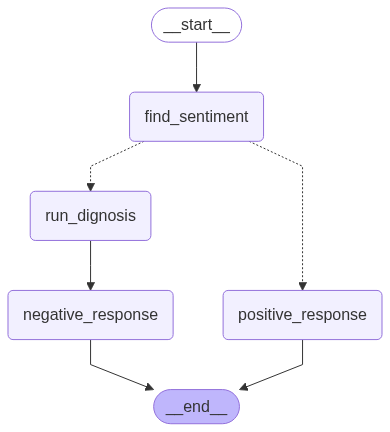

In [25]:
graph= StateGraph(ReviewState)

graph.add_node('find_sentiment',find_sentiment)
graph.add_node('positive_response',positive_response)
graph.add_node('run_dignosis',run_dignosis)
graph.add_node('negative_response',negative_response)

graph.add_edge(START,'find_sentiment')

graph.add_conditional_edges('find_sentiment',check_sentiment)

graph.add_edge('positive_response',END)

graph.add_edge('run_dignosis','negative_response')
graph.add_edge('negative_response',END)

workflow= graph.compile()
workflow

In [ ]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)